# Time Vector
In this notebook, focus only on the time vector. The hypothesis is: The vector difference bert("I eat lunch") - bert("I ate lunch") resides on some concentrated directions, and is disentangled from other factors.

In [49]:
import os, time, sys
import pandas as pd
import numpy as np
import spacy
import pickle
import transformers
from transformers import BertTokenizer, BertModel
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import colors as mcolors
colors = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)

import sklearn
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
import nltk
from nltk.tokenize import sent_tokenize
from tqdm import tqdm
import torch

from utils import timed_func

tags_to_tense = {
    "VB": "base", 
    "VBD": "past",
    "VBG": "present_participle",
    "VBN": "past_participle",
    "VBP": "non_3rd_singular_present",
    "VBZ": "3rd_singular_present"
}
verb_tags = ["VB", "VBD", "VBG", "VBN", "VBP", "VBZ"]

In [2]:
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
bert_model = BertModel.from_pretrained('bert-base-cased', output_hidden_states=False)
nlp = spacy.load("en_core_web_md")

In [3]:
@timed_func
def read_sst_sentences(verbose=True):
    """
    Output: list of spacy-processed Docs
    """
    L = []
    wordcounts = []
    with open("../data/stanfordSentimentTreebank/datasetSentences.txt", "r") as f:
        for line in f.readlines():
            raw_text = line.split("\t")[1]
            for sent in sent_tokenize(raw_text):
                doc = nlp(sent)
                L.append(doc)
                wordcounts.append(len(doc))
    if verbose:
        print ("SST contains {} sentences, avg words {:.2f}, stdvar {:.2f}.".format(
            len(wordcounts), np.mean(wordcounts), np.std(wordcounts)
        ))
    return L

@timed_func
def read_sst_sentences_plaintext(verbose=True):
    """
    Output: list of string
    """
    L = []
    wordcounts = []
    with open("../data/stanfordSentimentTreebank/datasetSentences.txt", "r") as f:
        for line in f.readlines():
            raw_text = line.split("\t")[1]
            for sent in sent_tokenize(raw_text):
                L.append(sent)
                wordcounts.append(len(sent.split()))
    if verbose:
        print ("SST contains {} sentences, avg words {:.2f}, stdvar {:.2f}.".format(
            len(wordcounts), np.mean(wordcounts), np.std(wordcounts)
        ))
    return L

#sst_sentences = read_sst_sentences()
sst_plaintext = read_sst_sentences_plaintext()

SST contains 11978 sentences, avg words 18.97, stdvar 9.24.
read_sst_sentences_plaintext done in 0.44 seconds.


In [4]:
@timed_func
def count_tags_freq(sentences, verb_only=True):
    tags_freq = {}
    for sent in sentences:
        for token in sent:
            t = token.tag_
            if t not in tags_freq:
                tags_freq[t] = 1
            else:
                tags_freq[t] += 1
                
    if verb_only:
        return [(k,tags_freq[k]) for k in tags]
    else:
        return [(k,tags_freq[k]) for k in tags_freq]

print(count_tags_freq(sst_sentences))

NameError: name 'sst_sentences' is not defined

In [ ]:
@timed_func
def histogram_sentence_tenses(sentences):
    # Count how many tenses each sentence has.
    num_tenses_histogram = {}
    for sent in sentences:
        indicator = [0] * len(verb_tags)
        for token in sent:
            if token.tag_ in verb_tags:
                indicator[tags.index(token.tag_)] = 1
        num = np.array(indicator).sum()
        if num not in num_tenses_histogram:
            num_tenses_histogram[num] = 1
            print(f"Example of {num} tenses:", sent, [token.tag_ for token in sent])
        else:
            num_tenses_histogram[num] += 1
    print(num_tenses_histogram)
    
histogram_sentence_tenses(sst_sentences)

### Some observations
1. There are many annotation errors in determining verb tenses. Need manual checks. (but the dataset size is only several thousands. Can be done within hours)  
2. Let me systematically determine the tense of a sentence with the tense of **the outmost verb** in constituency parsing.  

In [ ]:
@timed_func
def filter_past_tense_sentences_v1(sentences):
    # Intuition 1: if any "past tense" (VBD) verb form exists. This does not work well.
    results = []
    for sent in sentences:
        tags = [token.tag_ for token in sent]
        
        if "VBD" in tags:
            results.append(str(sent)+"\n")
        
        
    with open(os.path.join("20200701_outputs", "past_tense.txt"), "w+") as f:
        f.writelines(results)

filter_past_tense_sentences(sst_sentences)

In [5]:
from allennlp.predictors.predictor import Predictor
import allennlp_models.structured_prediction
allennlp_predictor = Predictor.from_path("https://storage.googleapis.com/allennlp-public-models/elmo-constituency-parser-2020.02.10.tar.gz")

In [6]:
def find_main_verb_and_tense(sentence):
    res = allennlp_predictor.predict(sentence=sentence)
    tr = nltk.tree.Tree.fromstring(res['trees'])
    treepositions = sorted(tr.treepositions(), key=lambda tup: len(tup))  # Level-order traversal. 
    for pos in treepositions:
        node = tr[pos]
        depth = len(pos)
        if hasattr(node, "label") and node.label() in verb_tags:  # The first occurrence
            return node.label(), node[0], tags_to_tense[node.label()]
    return None, None, None
                
find_main_verb_and_tense("If I brought you 10 dollars, can you buy me lunch?")

Your label namespace was 'pos'. We recommend you use a namespace ending with 'labels' or 'tags', so we don't add UNK and PAD tokens by default to your vocabulary.  See documentation for `non_padded_namespaces` parameter in Vocabulary.


('VB', 'buy', 'base')

In [7]:
find_main_verb_and_tense("The gorgeously elaborate continuation of `` The Lord of the Rings '' trilogy is so huge that a column of words can not adequately describe co-writer\/director Peter Jackson 's expanded vision of J.R.R.")

('VBZ', 'is', '3rd_singular_present')

In [15]:
@timed_func
def compute_tenses(plaintexts):
    tense_results = {}
    for text in tqdm(plaintexts):
        # Use the tense of the main verb 
        # (where the main verb is the highest verb in constituency parsing tree)
        verbtag, verb, tense = find_main_verb_and_tense(text)
        if verbtag is not None:
            if verbtag not in tense_results:
                tense_results[verbtag] = [(text, verb)]
            else:
                tense_results[verbtag].append(tuple([text, verb]))
    with open("20200701_outputs/tense_results.pkl", "wb+") as f:
        pickle.dump(tense_results, f)
        
compute_tenses(sst_plaintext)

100%|██████████| 11978/11978 [1:59:14<00:00,  1.67it/s] 

compute_tenses done in 7155.02 seconds.


In [23]:
with open("20200701_outputs/tense_results.pkl", "rb") as f:
    tense_results = pickle.load(f)
for verbtag in tense_results:
    print("\n{}: {}, {} sentences".format(verbtag, tags_to_tense[verbtag], len(tense_results[verbtag])))
    print(tense_results[verbtag][0])
    print(tense_results[verbtag][1])
    print(tense_results[verbtag][2])
    print(tense_results[verbtag][3])


VBZ: 3rd_singular_present, 6565 sentences
("The Rock is destined to be the 21st Century 's new `` Conan '' and that he 's going to make a splash even greater than Arnold Schwarzenegger , Jean-Claud Van Damme or Steven Segal .", 'is')
("The gorgeously elaborate continuation of `` The Lord of the Rings '' trilogy is so huge that a column of words can not adequately describe co-writer\\/director Peter Jackson 's expanded vision of J.R.R.", 'is')
('If you sometimes like to go to the movies to have fun , Wasabi is a good place to start .', 'is')
('The film provides some great insight into the neurotic mindset of all comics -- even those who have reached the absolute top of the game .', 'provides')

VB: base, 1372 sentences
("Emerges as something rare , an issue movie that 's so honest and keenly observed that it does n't feel like one .", 'Emerges')
("The movie 's ripe , enrapturing beauty will tempt those willing to probe its inscrutable mysteries .", 'tempt')
('Fuller would surely have c

In [25]:
len(tense_results["VBD"])

474

In [28]:
# Export to CSV for manually converting the tense into present
df_data = {"past_sent": [], "present_sent": [], "main_verb": []}
for item in tense_results["VBD"]:
    df_data["past_sent"].append(item[0])
    df_data["main_verb"].append(item[1])
    df_data["present_sent"].append("")
df = pd.DataFrame(df_data)
df.to_csv("20200701_outputs/past_to_main.csv", index=False)

In [31]:
# Used ~30 mins to annotate 150 lines out of 474
df = pd.read_csv("20200701_outputs/past_to_main_edited.csv")
df = df[~df.present_sent.isna()]
print(df.shape)
df.head()

(134, 4)


,past_sent,correct_tense,present_sent,main_verb
1,Though everything might be literate and smart ...,NaN,Though everything might be literate and smart ...,took
2,I loved it !,NaN,I love it !,loved
3,I enjoyed Time of Favor while I was watching i...,NaN,"I enjoy Time of Favor while I am watching it ,...",enjoyed
4,I admired this work a lot .,NaN,I admire this work a lot .,admired
5,"My goodness , Queen Latifah has a lot to offer...",NaN,"My goodness , Queen Latifah has a lot to offer...",seemed


In [44]:
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
bert_model = BertModel.from_pretrained('bert-base-cased', output_hidden_states=False)

def evaluate_contextual_diff(pair):
    source, target = pair[0], pair[1]
    src_ids = torch.tensor(bert_tokenizer.encode(source)).unsqueeze(0)
    src_vec = bert_model(src_ids)[0].mean(dim=1)[0]  # (768,) torch.tensor
    
    tgt_ids = torch.tensor(bert_tokenizer.encode(target)).unsqueeze(0)
    tgt_vec = bert_model(tgt_ids)[0].mean(dim=1)[0]
    
    d_emb = len(src_vec)  # 768
    diff = src_vec - tgt_vec
    return diff  # 768-dimensional torch.tensor

@timed_func
def time_vecs_heterogeneity_test_prep(df):
    """Let me compare heterogeneity of the time vector (diff by only syntax) vs. 
        (1) "pairs_totalrandom": randomly sampled sentences
        (2) "nonpairs_past_to_present": sampled from the corresponding tense (diff by syntax, but also contains time diff)
        (3) "pairs_both_past" and "pairs_both_present": sampled from the same tense (diff by semantics, but same tense)
    """
    pairs_past_to_present = []
    for i, row in df.iterrows():
        pairs_past_to_present.append(tuple([row.past_sent, row.present_sent]))

    pairs_totalrandom = []
    nonpairs_past_to_present = []
    pairs_both_past = []
    pairs_both_present = []

    past_sents = df.past_sent.tolist()
    pres_sents = df.present_sent.tolist()
    all_sents = past_sents + pres_sents
    for i in range(len(df)):
        rand_rowid1 = np.random.choice(range(len(df)))
        rand_rowid2 = np.random.choice(range(len(df)))
        rand_rowid3 = np.random.choice(range(len(df)))
        rand_rowid4 = np.random.choice(range(len(df)))
        rand_rowid5 = np.random.choice(range(len(df)))
        rand_rowid6 = np.random.choice(range(len(df)))
        pairs_both_past.append([past_sents[rand_rowid1], past_sents[rand_rowid2]])
        pairs_both_present.append([pres_sents[rand_rowid3], pres_sents[rand_rowid4]])
        nonpairs_past_to_present.append([past_sents[rand_rowid5], pres_sents[rand_rowid6]])
        pairs_totalrandom.append([np.random.choice(all_sents), np.random.choice(all_sents)])

    vecs1 = torch.stack([evaluate_contextual_diff(pair) for pair in pairs_past_to_present])
    vecs2 = torch.stack([evaluate_contextual_diff(pair) for pair in pairs_totalrandom])
    vecs3 = torch.stack([evaluate_contextual_diff(pair) for pair in nonpairs_past_to_present])
    vecs4 = torch.stack([evaluate_contextual_diff(pair) for pair in pairs_both_past])
    vecs5 = torch.stack([evaluate_contextual_diff(pair) for pair in pairs_both_present])
    
    return vecs1, vecs2, vecs3, vecs4, vecs5

vecs1, vecs2, vecs3, vecs4, vecs5 = time_vecs_heterogeneity_test_prep(df)

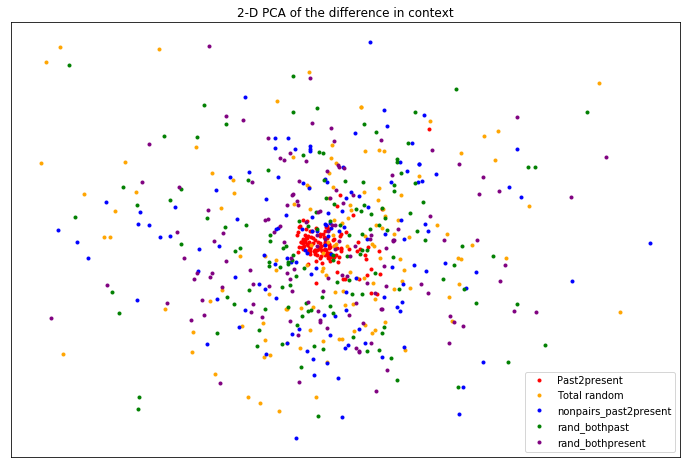

In [53]:
def pca_embed(vecs):
    pca = PCA(n_components=2)
    return pca.fit_transform(vecs.detach().numpy())

def make_plot(all_vecs, names):
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111)
    
    palette = [colors["red"], colors["orange"], colors["blue"], colors["green"], colors["purple"]][:len(names)]
    for i, vecs in enumerate(all_vecs):
        z = pca_embed(vecs)  # (n_pt, 2)
        ax.plot(z[:, 0], z[:, 1], "o", c=palette[i], markersize=3, label=names[i])
        
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    plt.legend()
    plt.title('2-D PCA of the difference in context')
    plt.show()
    
collections = [vecs1, vecs2, vecs3, vecs4, vecs5]
names = ["Past2present", "Total random", "nonpairs_past2present",
        "rand_bothpast", "rand_bothpresent"]
make_plot(collections, names)

In [57]:
for i, name in enumerate(names):
    vecs = collections[i]
    print ("{:<20}\t var {:.4f}".format(names[i], vecs.var().item()))

Past2present        	 var 0.0032
Total random        	 var 0.0524
nonpairs_past2present	 var 0.0497
rand_bothpast       	 var 0.0508
rand_bothpresent    	 var 0.0493


### Interpretations
Ok there are some positive results. The variance of syntactics (`past2present`) are much smaller than semantics (`nonpairs_past2present`, `rand_bothpast`, `rand_bothpresent`), which are somewhat smaller than syntactics + semantics (`total_ranodm`).

## Geometry of time vectors
(inspired from Kawin's paper) I also want to check the similarity within vectors from each set `vecsi` (i=1,2,3,4,5). This will be similar to variance.

In [67]:
def cosine_self_similarity(vecs, n_sample=100):
    v1 = vecs[np.random.choice(range(len(vecs)), n_sample)]
    v2 = vecs[np.random.choice(range(len(vecs)), n_sample)]
    sim = torch.nn.functional.cosine_similarity(v1, v2)
    return sim.mean().item()

for i, name in enumerate(names):
    vecs = collections[i]
    sim = cosine_self_similarity(vecs)
    print ("{:<20}\t sim {:.4f}".format(name, sim))

Past2present        	 sim 0.2010
Total random        	 sim -0.0021
nonpairs_past2present	 sim 0.0076
rand_bothpast       	 sim 0.0202
rand_bothpresent    	 sim 0.0078
